(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

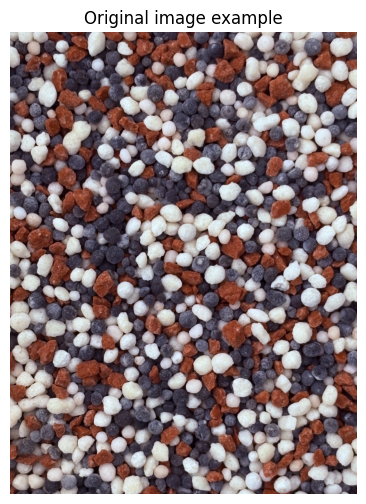

In [6]:
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor
import torch
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm  # Added missing import

# === FILTER CONFIG ===
BEAD_MASKS = 4             # Number of clusters
CONTRAST_FACTOR = 1.4       # >1 increases contrast
SATURATION_FACTOR = 2.5       # >1 increases vividity
BRIGHTNESS_OFFSET = 0      # Offset for brightness adjustment

# === Load the image path ===
img_path_list = []
folder_path_1 = "pictures/14-7-35"
folder_path_2 = "pictures/15-4-20"
folder_path_3 = "pictures/15-15-15"
folder_path_4 = "pictures/18-4-5"

for path in [folder_path_1, folder_path_2, folder_path_3, folder_path_4]:
    if not os.path.exists(path):
        print(f"Warning: Folder {path} does not exist, skipping...")
        continue
    # Get all image paths from the folders
    image_path = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_path:  # Only add if folder contains images
        img_path_list.append(image_path)

if not img_path_list:
    raise FileNotFoundError("No valid image folders found.")

# === Load image to rgb ===
def load_img_as_rgb(img_path):
    image_bgr = cv2.imread(img_path)  # Removed duplicate line
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === Image enhancement with comprehensive clipping ===
def enhance_image(img_path, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    image = load_img_as_rgb(img_path)
    # Create a mask for pure green pixels (RGB = [0, 255, 0])
    green_mask = np.all(image == [0, 255, 0], axis=-1)

    # Backup green pixels
    green_pixels = image[green_mask].copy()  # Added .copy() for safety

    # Ensure input is float32 for precise calculations
    img = np.clip(image.astype(np.float32), 0, 255)

    # Apply contrast with clipping
    img = np.clip(contrast * img, 0, 255)

    # Apply brightness adjustment with clipping
    img = np.clip(img + brightness, 0, 255)

    # Convert to uint8 for HSV conversion
    img_uint8 = img.astype(np.uint8)

    # Convert to HSV and apply saturation boost
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation, 0, 255)
    hsv = np.clip(hsv, 0, 255)

    # Convert back to RGB
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    # Restore the original green pixels
    if np.any(green_mask):  # Only restore if there are green pixels
        enhanced[green_mask] = green_pixels

    return enhanced


# === Grouping points ===
def get_all_grouped_points(label, labels, valid_indices, W):
    point_coords = []
    group_indices = np.where(labels == label)[0]
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])
    return np.array(point_coords)

# === Processing starts here ===
def get_cluster_mask(image_path):
    enhanced_image = enhance_image(image_path)
    H, W, _ = enhanced_image.shape
    pixels = enhanced_image.reshape(-1, 3)

    print("Filtering out pure green pixels...")
    non_green_indices = np.any(pixels != [0, 255, 0], axis=1)  # Fixed variable name
    pixels_non_green = pixels[non_green_indices]  # Fixed variable name

    if len(pixels_non_green) == 0:
        raise ValueError("No non-green pixels found in the image.")

    print("Running KMeans clustering into", BEAD_MASKS, "clusters...")
    kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels_non_green)

    print("Preparing valid indices for mapping back...")
    valid_indices = np.where(non_green_indices)[0]  # Fixed variable name

    all_masks = []
    all_point_coords = []

    print("Processing each cluster to create masks and points...")
    # Fixed tqdm usage - removed desc parameter from range()
    for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
        mask_flat = np.zeros(H * W, dtype=bool)
        cluster_pixel_indices = valid_indices[labels == cluster_label]
        mask_flat[cluster_pixel_indices] = True
        mask_2d = mask_flat.reshape(H, W)
        point_coords = get_all_grouped_points(cluster_label, labels, valid_indices, W)
        all_masks.append(mask_2d)
        all_point_coords.append(point_coords)
        print(f"Cluster {cluster_label}: mask created with {len(point_coords)} points.")

    print("Sorting clusters by total RGB brightness...")

    # Compute average brightness for each mask (proportional, not cumulative)
    brightness_averages = []
    for mask in all_masks:
        masked_pixels = enhanced_image[mask]  # shape: (N, 3) for RGB
        if len(masked_pixels) == 0:
            brightness = 0  # Avoid division by zero
        else:
            brightness = np.mean(masked_pixels)  # Average brightness
        brightness_averages.append(brightness)

    # Get sorted indices from brightest to darkest
    sorted_indices = np.argsort(brightness_averages)[::-1]  # Descending order

    # Reorder clusters by brightness
    all_masks = [all_masks[i] for i in sorted_indices]
    return all_masks

def get_area(image_path):
    all_masks = get_cluster_mask(image_path)
    # === Compute Cluster Areas ===
    cluster_areas = []
    for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
        area = np.sum(mask > 0)  # Counts all non-zero (i.e., masked) pixels
        cluster_areas.append(area)

    # === Print Area Summary ===
    print("\nCluster Area Summary:")
    for i, area in enumerate(cluster_areas):
        print(f"Cluster {i+1}: {area} pixels")

    print("Total Cluster Area:", sum(cluster_areas))
    return cluster_areas

# === Visualize the first image ===
image_rgb = load_img_as_rgb(img_path_list[1][0])  # Load the first image from the first folder
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original image example")
plt.axis('off')


Filtering out pure green pixels...
Running KMeans clustering into 4 clusters...
Preparing valid indices for mapping back...
Processing each cluster to create masks and points...


Clusters:  25%|██▌       | 1/4 [00:02<00:07,  2.41s/it]

Cluster 0: mask created with 3477463 points.


Clusters:  50%|█████     | 2/4 [00:05<00:05,  2.71s/it]

Cluster 1: mask created with 4046367 points.


Clusters:  75%|███████▌  | 3/4 [00:06<00:02,  2.17s/it]

Cluster 2: mask created with 2494182 points.


Clusters: 100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


Cluster 3: mask created with 2174756 points.
Sorting clusters by total RGB brightness...


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 82.48it/s]



Cluster Area Summary:
Cluster 1: 4046367 pixels
Cluster 2: 2174756 pixels
Cluster 3: 2494182 pixels
Cluster 4: 3477463 pixels
Total Cluster Area: 12192768
Areas for the first image: [np.int64(4046367), np.int64(2174756), np.int64(2494182), np.int64(3477463)]


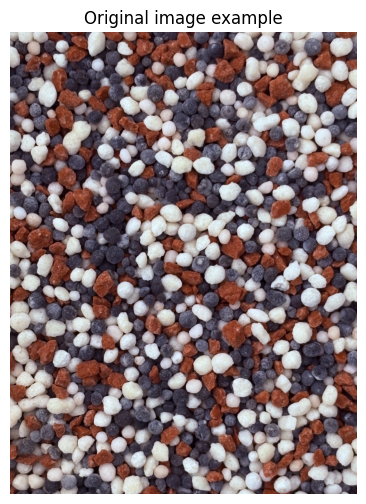

In [ ]:


# === Get areas for the first image ===
areas = get_area(img_path_list[1][0])
print("Areas for the first image:", areas)


Enhancing image...
Start: Showing original image...


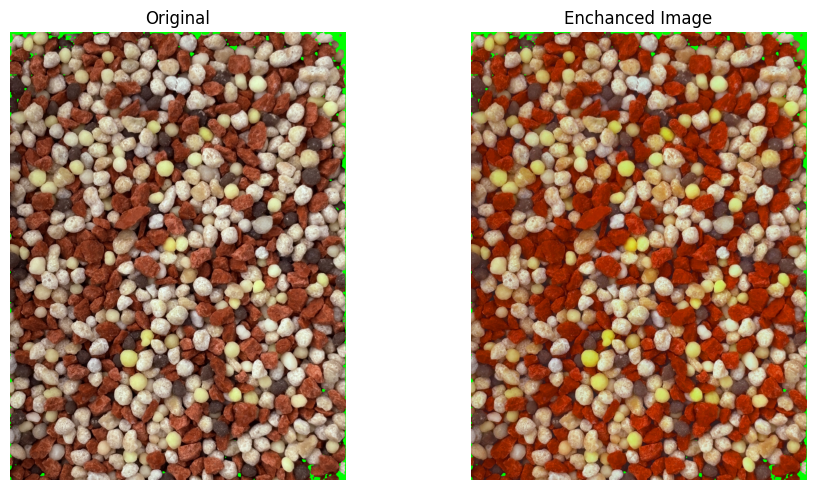

Getting image shape and flattening pixels...
Filtering out pure green pixels...
Running KMeans clustering into 4 clusters...
Preparing valid indices for mapping back...
Processing each cluster to create masks and points...


Clusters:  25%|██▌       | 1/4 [00:02<00:06,  2.31s/it]

Cluster 0: mask created with 3398332 points.


Clusters:  50%|█████     | 2/4 [00:03<00:03,  1.85s/it]

Cluster 1: mask created with 2890965 points.


Clusters:  75%|███████▌  | 3/4 [00:05<00:01,  1.94s/it]

Cluster 2: mask created with 2772715 points.


Clusters: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Cluster 3: mask created with 3010783 points.
Sorting clusters by total RGB brightness...
All clusters processed. Starting visualization...


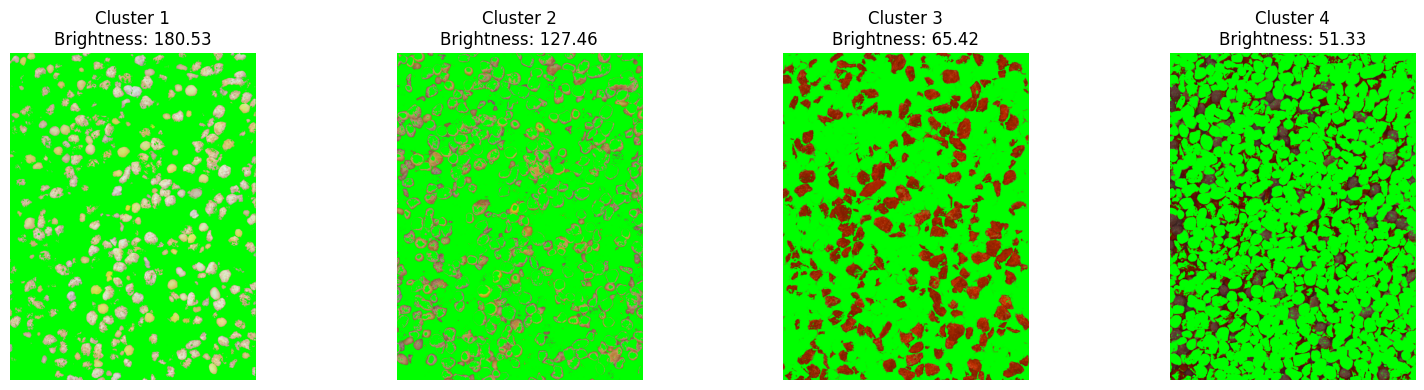

In [17]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm  # Progress bar

# === CONFIG ===
BEAD_MASKS = 4             # Number of clusters
CONTRAST_FACTOR = 0.8       # >1 increases contrast
SATURATION_FACTOR = 2       # >1 increases vividity
BRIGHTNESS_OFFSET = 40      # Offset for brightness adjustment

# === Image enhancement with comprehensive clipping ===
def enhance_image(image, contrast=CONTRAST_FACTOR, saturation=SATURATION_FACTOR, brightness=BRIGHTNESS_OFFSET):
    # Create a mask for pure green pixels (RGB = [0, 255, 0])
    green_mask = np.all(image == [0, 255, 0], axis=-1)

    # Backup green pixels
    green_pixels = image[green_mask]

    # Ensure input is float32 for precise calculations
    img = np.clip(image.astype(np.float32), 0, 255)

    # Apply contrast with clipping
    img = np.clip(contrast * img, 0, 255)

    # Apply brightness adjustment with clipping
    img = np.clip(img + brightness, 0, 255)

    # Convert to uint8 for HSV conversion
    img_uint8 = img.astype(np.uint8)

    # Convert to HSV and apply saturation boost
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[..., 1] = np.clip(hsv[..., 1] * saturation, 0, 255)
    hsv = np.clip(hsv, 0, 255)

    # Convert back to RGB
    enhanced = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)

    # Restore the original green pixels
    enhanced[green_mask] = green_pixels

    return enhanced



# === Grouping points ===
def get_all_grouped_points(label):
    point_coords = []
    group_indices = np.where(labels == label)[0]
    for indice in group_indices:
        original_flat_index = valid_indices[indice]
        y, x = divmod(original_flat_index, W)
        point_coords.append([x, y])
    return np.array(point_coords)

print("Enhancing image...")
enhanced_image = enhance_image(masked_image)

# === Processing starts here ===
print("Start: Showing original image...")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Enchanced Image")
plt.axis('off')
plt.tight_layout()
plt.show()

print("Getting image shape and flattening pixels...")
H, W, _ = enhanced_image.shape
pixels = enhanced_image.reshape(-1, 3)

print("Filtering out pure green pixels...")
non_black_indices = np.any(pixels != [0, 255, 0], axis=1)
pixels_non_black = pixels[non_black_indices]

print("Running KMeans clustering into", BEAD_MASKS, "clusters...")
kmeans = KMeans(n_clusters=BEAD_MASKS, random_state=42)
labels = kmeans.fit_predict(pixels_non_black)

print("Preparing valid indices for mapping back...")
valid_indices = np.where(non_black_indices)[0]

all_masks = []
all_point_coords = []

print("Processing each cluster to create masks and points...")
for cluster_label in tqdm(range(BEAD_MASKS), desc="Clusters"):
    mask_flat = np.zeros(H * W, dtype=bool)
    cluster_pixel_indices = valid_indices[labels == cluster_label]
    mask_flat[cluster_pixel_indices] = True
    mask_2d = mask_flat.reshape(H, W)
    point_coords = get_all_grouped_points(cluster_label)
    all_masks.append(mask_2d)
    all_point_coords.append(point_coords)
    print(f"Cluster {cluster_label}: mask created with {len(point_coords)} points.")

print("Sorting clusters by total RGB brightness...")

# Compute average brightness for each mask (proportional, not cumulative)
brightness_averages = []
for mask in all_masks:
    masked_pixels = enhanced_image[mask]  # shape: (N, 3) for RGB
    if len(masked_pixels) == 0:
        brightness = 0  # Avoid division by zero
    else:
        brightness = np.mean(masked_pixels)  # Average brightness
    brightness_averages.append(brightness)


# Get sorted indices from brightest to darkest
sorted_indices = np.argsort(brightness_averages)[::-1]  # Descending order

# Reorder clusters by brightness
all_masks = [all_masks[i] for i in sorted_indices]
all_point_coords = [all_point_coords[i] for i in sorted_indices]

print("All clusters processed. Starting visualization...")

plt.figure(figsize=(16, 4))
for i in range(BEAD_MASKS):
    cluster_img = np.full_like(enhanced_image, fill_value=[0, 255, 0])  # Green background
    mask = all_masks[i]
    cluster_img[mask] = enhanced_image[mask]  # Overlay original colors of cluster

    avg_brightness = brightness_averages[sorted_indices[i]]
    plt.subplot(1, BEAD_MASKS, i + 1)
    plt.imshow(cluster_img)
    plt.title(f"Cluster {i+1}\nBrightness: {avg_brightness:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Measuring cluster areas: 100%|██████████| 4/4 [00:00<00:00, 70.78it/s]


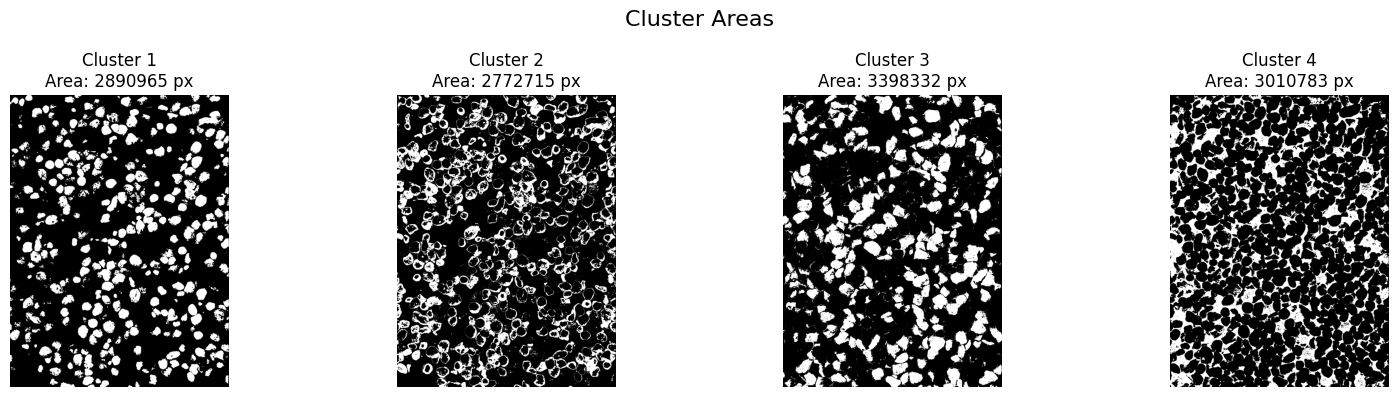


Cluster Area Summary:
Cluster 1: 2890965 pixels
Cluster 2: 2772715 pixels
Cluster 3: 3398332 pixels
Cluster 4: 3010783 pixels
Total Cluster Area: 12072795


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# === Assuming `all_masks` is a list of boolean or binary masks (H x W) ===
# all_masks = [...]  # This should already be created before this script runs

# === Compute Cluster Areas ===
cluster_areas = []
for i, mask in enumerate(tqdm(all_masks, desc="Measuring cluster areas")):
    area = np.sum(mask > 0)  # Counts all non-zero (i.e., masked) pixels
    cluster_areas.append(area)

# === Visualization of Mask with Area ===
plt.figure(figsize=(16, 4))
for i, (mask, area) in enumerate(zip(all_masks, cluster_areas)):
    plt.subplot(1, len(all_masks), i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {i+1}\nArea: {area} px")
    plt.axis('off')
plt.suptitle("Cluster Areas", fontsize=16)
plt.tight_layout()
plt.show()

# === Print Area Summary ===
print("\nCluster Area Summary:")
for i, area in enumerate(cluster_areas):
    print(f"Cluster {i+1}: {area} pixels")

print("Total Cluster Area:", sum(cluster_areas))


In [14]:
print(cluster_areas)

[np.int64(2233986), np.int64(2713507), np.int64(3994426), np.int64(3130876)]


In [ ]:
def get_npk(cluster_areas):
    
    shadow_area = 2000000  # Area of the shadow

    white_beads = cluster_areas[0]
    stain_beads = cluster_areas[1]
    red_beads = cluster_areas[2]
    black_beads = cluster_areas[3] - shadow_area

    white_composition = {'N': 46, 'P': 0, 'K': 0}
    stain_composition = {'N': 21, 'P': 0, 'K': 0}
    red_composition   = {'N': 0, 'P': 0, 'K': 60}
    black_composition = {'N': 18, 'P': 46, 'K': 0}

    npk_total = {'N': 0, 'P': 0, 'K': 0}

    for key in npk_total:
        npk_total[key] += red_composition[key] * red_beads
        npk_total[key] += white_composition[key] * white_beads
        npk_total[key] += stain_composition[key] * stain_beads
        npk_total[key] += black_composition[key] * black_beads

    total_beads = sum(cluster_areas) - shadow_area
    npk_composition = {key: round(val / total_beads, 2) for key, val in npk_total.items()}
    
    return npk_composition

print(f"NPK Composition: {get_npk(cluster_areas)} in percantage")

NPK Composition: {'N': np.float64(20.79), 'P': np.float64(4.62), 'K': np.float64(20.24)} in percantage


In [ ]:
# Data preparation for regression plotting

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Fixed NPK composition per pixel of each cluster color
NPK_PER_PIXEL = {
    'white': {'N': 46, 'P': 0,  'K': 0},
    'stain': {'N': 21, 'P': 0,  'K': 0},
    'red':   {'N': 0,  'P': 0,  'K': 60},
    'black': {'N': 18, 'P': 46, 'K': 0}
}

# Training data: observed cluster areas (pixels) from image
# Columns = [white_area, stain_area, red_area, black_area]
X_area = np.array([
    [100000, 20000, 30000, 40000],
    [150000, 30000, 40000, 45000],
    [120000, 25000, 35000, 37000],
    # Add more real samples for better accuracy
])

# Corresponding actual NPK measurements from lab (ground truth)
# Each row = [N, P, K]
y_actual_npk = np.array([
    [35, 10, 18],
    [40, 15, 24],
    [38, 13, 21],
    # Add more matched NPK data
])

# Calculate approximate effective pixel areas for each bead type from actual NPK:
# Using known NPK percentages to estimate true "effective pixel count"
W = np.array([
    [1/46, 0,    0],     # white: N only
    [1/21, 0,    0],     # stain: N only
    [0,    0, 1/60],     # red:   K only
    [1/18, 1/46, 0]      # black: N and P
])

# Calculate approximate effective areas based on actual NPK values
# This make fitting for regression faster and more accurate
approx_effective_areas = y_actual_npk @ W.T  # shape: (samples, 4)

# Train one regression model per bead type (column)
regressor = LinearRegression()
regressor.fit(X_area, approx_effective_areas)

def predict_npk_with_effectiveness_models(cluster_areas):
    cluster_areas = np.array(cluster_areas).reshape(1, -1)  # shape (1,4)

    # Predict corrected effective pixel areas for all bead types at once
    effective_areas = regressor.predict(cluster_areas)[0]
    effective_areas = np.clip(effective_areas, 0, None)  # clip negatives

    # Calculate final NPK using fixed nutrient values and effective pixel areas
    N = (
        NPK_PER_PIXEL['white']['N'] * effective_areas[0] +
        NPK_PER_PIXEL['stain']['N'] * effective_areas[1] +
        NPK_PER_PIXEL['black']['N'] * effective_areas[3]
    )
    P = NPK_PER_PIXEL['black']['P'] * effective_areas[3]
    K = NPK_PER_PIXEL['red']['K'] * effective_areas[2]

    total_mass = np.sum(effective_areas)
    return {
        'N': round(N / total_mass, 2) if total_mass > 0 else 0,
        'P': round(P / total_mass, 2) if total_mass > 0 else 0,
        'K': round(K / total_mass, 2) if total_mass > 0 else 0,
    }

# Example prediction
example_areas = [130000, 24000, 31000, 36000]
print("Improved NPK prediction:", predict_npk_with_effectiveness_models(example_areas))
